In [1]:

import os, re, glob, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report
from google.colab import drive


In [2]:

# === Configuración ===
drive.mount('/content/drive', force_remount=True)
DATA_DIR   = "/content/drive/MyDrive/IA-PROYECTO/data/UTKFace"
OUTPUT_DIR = "/content/drive/MyDrive/IA-PROYECTO/age_cnn_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# -----------------------
# 2) Configuración
# -----------------------
IMG_SIZE            = (192, 192)
BATCH_SIZE          = 32
EPOCHS              = 40
SEED                = 42
LOSS_W_AGE          = 0.7
LOSS_W_BUCKET       = 0.3
MINOR_AGE_CUTOFF    = 19
WEIGHT_FOR_MINOR    = 3.0
WEIGHT_FOR_ADULT    = 1.0
CLASS_NAMES         = ["child(0-12)", "teen(13-18)", "young(19-30)", "adult(31+)"]

tf.random.set_seed(SEED)
np.random.seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE


Mounted at /content/drive


In [3]:

# === Cargar rutas y extraer edades del nombre de archivo ===
# Formato UTKFace: [age]_[gender]_[race]_[date&time].jpg
pat = re.compile(r"^(\d+)_([01])_([0-4])_.*\.jpg$", re.I)

paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.jpg")))
ages = []
file_paths = []

for p in paths:
    fname = os.path.basename(p)
    m = pat.match(fname)
    if not m:
        continue
    age = int(m.group(1))
    if age < 0 or age > 116:
        continue
    ages.append(age)
    file_paths.append(p)

ages = np.array(ages, dtype=np.float32)
file_paths = np.array(file_paths)
print("Total imágenes válidas:", len(file_paths))
print("Rango de edades:", ages.min(), "->", ages.max())


Total imágenes válidas: 13412
Rango de edades: 1.0 -> 116.0


In [4]:

# === Buckets de edad ===
# 0: Niño (0–12), 1: Adolescente (13–18), 2: Adulto Joven (19–30), 3: Adulto (31+)
def age_to_bucket(age):
    a = int(age)
    if a <= 12: return 0
    if a <= 18: return 1
    if a <= 30: return 2
    return 3

buckets = np.array([age_to_bucket(a) for a in ages], dtype=np.int32)


In [5]:

# === Split estratificado por buckets ===
idx = np.arange(len(file_paths))
train_idx, test_idx = train_test_split(
    idx, test_size=0.15, random_state=SEED, stratify=buckets
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.1765, random_state=SEED, stratify=buckets[train_idx]
)  # ~15% val, 70% train, 15% test

def take(indexes):
    return file_paths[indexes], ages[indexes], buckets[indexes]

train_paths, train_ages, train_buckets = take(train_idx)
val_paths,   val_ages,   val_buckets   = take(val_idx)
test_paths,  test_ages,  test_buckets  = take(test_idx)

print("Train:", len(train_paths), " Val:", len(val_paths), " Test:", len(test_paths))


Train: 9387  Val: 2013  Test: 2012


In [6]:

# === tf.data pipeline ===
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def augment(img):
    # Aumentos suaves que no distorsionan facciones
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_brightness(img, 0.05)
    # recorte aleatorio leve
    crop_frac = tf.random.uniform([], 0.9, 1.0)
    new_size = tf.cast(tf.multiply(tf.constant(IMG_SIZE, tf.float32), crop_frac), tf.int32)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE[0], IMG_SIZE[1])
    img = tf.image.resize(img, IMG_SIZE)
    return img

def make_ds(paths, ages, buckets, train=False):
    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_ages = tf.data.Dataset.from_tensor_slices(ages)
    ds_buckets = tf.data.Dataset.from_tensor_slices(buckets)
    ds = tf.data.Dataset.zip((ds_paths, ds_ages, ds_buckets))

    def _map(path, age, bucket):
        img = preprocess_image(path)
        if train:
            img = augment(img)
        # targets: age (float), buckets one-hot
        bucket_oh = tf.one_hot(bucket, 4, dtype=tf.float32)
        return img, {"age": tf.expand_dims(age, -1), "bucket": bucket_oh}

    if train:
        ds = ds.shuffle(8192, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_paths, train_ages, train_buckets, train=True)
val_ds   = make_ds(val_paths,   val_ages,   val_buckets,   train=False)
test_ds  = make_ds(test_paths,  test_ages,  test_buckets,  train=False)


In [7]:

# === Pérdida ponderada para priorizar menores ===
@tf.function
def weighted_mae(y_true, y_pred):
    # y_true shape: (batch, 1)
    age_true = y_true[:, 0]
    weights = tf.where(age_true < MINOR_AGE_CUTOFF, WEIGHT_FOR_MINOR, WEIGHT_FOR_ADULT)
    mae = tf.abs(y_true - y_pred)[:, 0]
    return tf.reduce_mean(weights * mae)


In [8]:

# === CNN===
L2 = 1e-4

def se_block(x, r=16):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(c//r, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1,1,c))(s)
    return layers.Multiply()([x, s])

def res_block(x, filters, k=3, s=1, drop=0.0):
    shortcut = x
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(filters, k, strides=1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters or s != 1:
        shortcut = layers.Conv2D(filters, 1, strides=s, padding="same", use_bias=False,
                                 kernel_regularizer=regularizers.l2(L2))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    x = se_block(x)
    if drop>0: x = layers.Dropout(drop)(x)
    return x

inputs = layers.Input(shape=IMG_SIZE + (3,), name="image")
x = layers.Conv2D(64, 3, padding="same", use_bias=False,
                  kernel_regularizer=regularizers.l2(L2))(inputs)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

# Etapas tipo “ResNet-lite”
x = res_block(x, 64,  s=1, drop=0.0)
x = res_block(x, 64,  s=1, drop=0.0)
x = layers.MaxPooling2D()(x)

x = res_block(x, 128, s=1, drop=0.0)
x = res_block(x, 128, s=1, drop=0.1)
x = layers.MaxPooling2D()(x)

x = res_block(x, 256, s=1, drop=0.1)
x = res_block(x, 256, s=1, drop=0.1)
x = layers.MaxPooling2D()(x)

x = res_block(x, 512, s=1, drop=0.2)
x = res_block(x, 512, s=1, drop=0.2)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(L2))(x)
x = layers.Dropout(0.3)(x)

age_output    = layers.Dense(1, activation="linear",   name="age")(x)
bucket_output = layers.Dense(4, activation="softmax", name="bucket")(x)

model = models.Model(inputs, [age_output, bucket_output], name="AgeCNN_Large")
try:
    opt = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-4, weight_decay=1e-4)
except Exception:
    opt = tf.keras.optimizers.Adam(1e-4)

model.compile(
    optimizer=opt,
    loss={"age": weighted_mae, "bucket": "categorical_crossentropy"},
    loss_weights={"age": LOSS_W_AGE, "bucket": LOSS_W_BUCKET},
    metrics={"age": ["mae"], "bucket": ["accuracy",
                                        tf.keras.metrics.Precision(name="precision"),
                                        tf.keras.metrics.Recall(name="recall")]}
)
model.summary()

Model: "AgeCNN_Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 192, 192,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 192,  │      1,728 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 192,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 192, 192,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 192, 192,  │     36,864 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 192, 192,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 192, 192,  │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 192, 192,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 192, 192,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        576 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 192, 192,  │          0 │ re_lu_2[0][0],    │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 192, 192,  │     36,864 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_3[0][0]  

 Total params: 11,401,157 (43.49 MB)

 Trainable params: 11,391,557 (43.46 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [10]:

# === Callbacks ===
ckpt_path = os.path.join(OUTPUT_DIR, "best_age_cnn_final.keras")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_bucket_recall", mode="max",
                                       save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_bucket_recall", mode="max",
                                     patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
]


In [11]:

# === Entrenamiento ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - age_loss: 22.5056 - age_mae: 19.8861 - bucket_accuracy: 0.4156 - bucket_loss: 1.4534 - bucket_precision: 0.4378 - bucket_recall: 0.2874 - loss: 16.6377
Epoch 1: val_bucket_recall improved from -inf to 0.42971, saving model to /content/drive/MyDrive/IA-PROYECTO/age_cnn_final/best_age_cnn_final.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 282s 744ms/step - age_loss: 22.4911 - age_mae: 19.8688 - bucket_accuracy: 0.4156 - bucket_loss: 1.4537 - bucket_precision: 0.4378 - bucket_recall: 0.2876 - loss: 16.6277 - val_age_loss: 18.9096 - val_age_mae: 12.3257 - val_bucket_accuracy: 0.4297 - val_bucket_loss: 1.4129 - val_bucket_precision: 0.4297 - val_bucket_recall: 0.4297 - val_loss: 14.1015 - learning_rate: 1.0000e-04
Epoch 2/40
293/294 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - age_loss: 15.6142 - age_mae: 11.6785 - bucket_accuracy: 0.4267 - bucket_loss: 1.4876 - bucket_precision: 0.4419 - bucket_recall: 0.3828 - loss: 11.8175
Epoch 2: val_bucket_recall 

In [26]:

# === Evaluación detallada ===
pred_age, pred_bucket_prob = model.predict(test_ds, verbose=1)
y_true_age = []
y_true_bucket = []

for _, y in test_ds:
    y_true_age.append(y['age'].numpy())
    y_true_bucket.append(y['bucket'].numpy())
y_true_age = np.concatenate(y_true_age, axis=0)[:,0]
y_true_bucket = np.argmax(np.concatenate(y_true_bucket, axis=0), axis=1)

pred_age = pred_age[:,0]
pred_bucket = np.argmax(pred_bucket_prob, axis=1)

mae_global = mean_absolute_error(y_true_age, pred_age)
print("MAE global:", round(mae_global, 3))

def subgroup_mae(mask, name):
    if mask.sum() == 0:
        print(f"{name}: sin datos")
        return
    print(f"{name} MAE:", round(mean_absolute_error(y_true_age[mask], pred_age[mask]), 3))

mask_child = (y_true_age <= 12)
mask_teen  = (y_true_age >= 13) & (y_true_age <= 18)
mask_young = (y_true_age >= 19) & (y_true_age <= 30)
mask_adult = (y_true_age >= 31)

subgroup_mae(mask_child, "Niños (0–12)")
subgroup_mae(mask_teen,  "Adolescentes (13–18)")
subgroup_mae(mask_young, "Adultos jóvenes (19–30)")
subgroup_mae(mask_adult, "Adultos (31+)")

print("\nReporte de clasificación por buckets (pred vs real):")
print(classification_report(y_true_bucket, pred_bucket, target_names=CLASS_NAMES, digits=3))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
MAE global: 8.127
Niños (0–12) MAE: 12.239
Adolescentes (13–18) MAE: 9.399
Adultos jóvenes (19–30) MAE: 3.703
Adultos (31+) MAE: 11.788

Reporte de clasificación por buckets (pred vs real):
              precision    recall  f1-score   support

 child(0-12)      1.000     0.249     0.398       173
 teen(13-18)      0.000     0.000     0.000        77
young(19-30)      0.605     0.639     0.622       898
  adult(31+)      0.646     0.763     0.700       864

    accuracy                          0.634      2012
   macro avg      0.563     0.413     0.430      2012
weighted avg      0.633     0.634     0.612      2012



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:

# === Política conservadora para acceso ===
# Regla: si el modelo predice "adolescente" con prob >= teen_threshold y edad_pred < 21,
# forzar edad final = min(edad_pred, 18). Esto reduce falsos negativos (menores que pasan).
teen_threshold = 0.35  # puedes ajustar entre 0.3 y 0.6 según recall
teen_index = 1

def final_age_and_access(age_pred, bucket_prob, teen_threshold=teen_threshold):
    teen_prob = float(bucket_prob[teen_index])
    final_age = float(age_pred)
    if teen_prob >= teen_threshold and final_age < 21:
        final_age = min(final_age, 18.0)
    # Política de acceso: permitir solo si final_age >= 18.5 (margen de seguridad)
    can_access = final_age >= 18.5
    return final_age, can_access

# Ejemplo usando el primer batch del test
for imgs, y in test_ds.take(1):
    pa, pb = model.predict(imgs, verbose=0)
    for i in range(min(5, len(pa))):
        fa, ok = final_age_and_access(pa[i][0], pb[i])
        print(f"Edad_pred={pa[i][0]:.2f} -> Edad_final={fa:.2f} | Acceso={'PERMITIDO' if ok else 'DENEGADO'}")


Edad_pred=28.79 -> Edad_final=28.79 | Acceso=PERMITIDO
Edad_pred=5.17 -> Edad_final=5.17 | Acceso=DENEGADO
Edad_pred=27.66 -> Edad_final=27.66 | Acceso=PERMITIDO
Edad_pred=38.33 -> Edad_final=38.33 | Acceso=PERMITIDO
Edad_pred=31.66 -> Edad_final=31.66 | Acceso=PERMITIDO


In [14]:

# === Guardar historia y notas ===
hist_path = os.path.join(OUTPUT_DIR, "training_history.json")
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({k: [float(x) for x in v] for k, v in history.history.items()}, f, ensure_ascii=False, indent=2)

print("Guardado modelo  ->", ckpt_path)
print("Guardado history ->", hist_path)


Guardado modelo  -> /content/drive/MyDrive/IA-PROYECTO/age_cnn_final/best_age_cnn_final.keras
Guardado history -> /content/drive/MyDrive/IA-PROYECTO/age_cnn_final/training_history.json


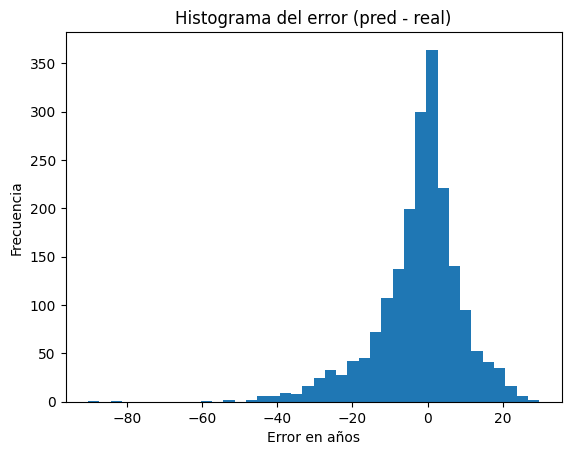

In [15]:
import numpy as np
import matplotlib.pyplot as plt

errors = pred_age - y_true_age  # >0 = sobreestima, <0 = subestima

plt.figure()
plt.hist(errors, bins=40)
plt.title("Histograma del error (pred - real)")
plt.xlabel("Error en años")
plt.ylabel("Frecuencia")
plt.show()

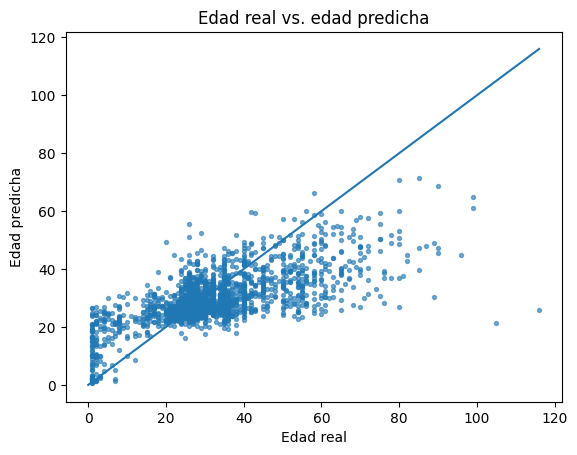

In [16]:
plt.figure()
plt.scatter(y_true_age, pred_age, s=8, alpha=0.6)
min_age = max(0, int(min(y_true_age.min(), pred_age.min())))
max_age = int(max(y_true_age.max(), pred_age.max()))
plt.plot([min_age, max_age], [min_age, max_age])
plt.title("Edad real vs. edad predicha")
plt.xlabel("Edad real")
plt.ylabel("Edad predicha")
plt.show()

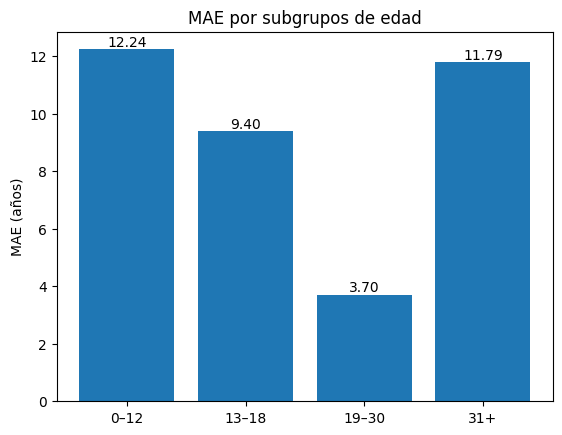

In [18]:
from sklearn.metrics import mean_absolute_error

mask_child = (y_true_age <= 12)
mask_teen  = (y_true_age >= 13) & (y_true_age <= 18)
mask_young = (y_true_age >= 19) & (y_true_age <= 30)
mask_adult = (y_true_age >= 31)

labels = ["0–12", "13–18", "19–30", "31+"]
maes = [
    mean_absolute_error(y_true_age[mask_child], pred_age[mask_child]) if mask_child.any() else np.nan,
    mean_absolute_error(y_true_age[mask_teen],  pred_age[mask_teen])  if mask_teen.any()  else np.nan,
    mean_absolute_error(y_true_age[mask_young], pred_age[mask_young]) if mask_young.any() else np.nan,
    mean_absolute_error(y_true_age[mask_adult], pred_age[mask_adult]) if mask_adult.any() else np.nan,
]

plt.figure()
plt.bar(labels, maes)
plt.title("MAE por subgrupos de edad")
plt.ylabel("MAE (años)")
for i, v in enumerate(maes):
    if not np.isnan(v):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.show()

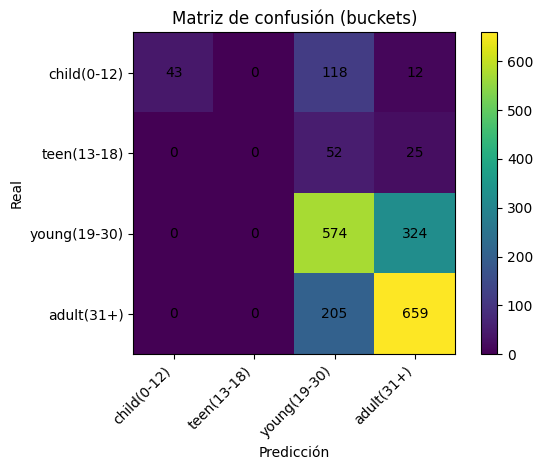

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_bucket, pred_bucket, labels=[0,1,2,3])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión (buckets)")
plt.colorbar()
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)
plt.xlabel("Predicción")
plt.ylabel("Real")

# Anotar valores
th = cm.max() / 2.0 if cm.size > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

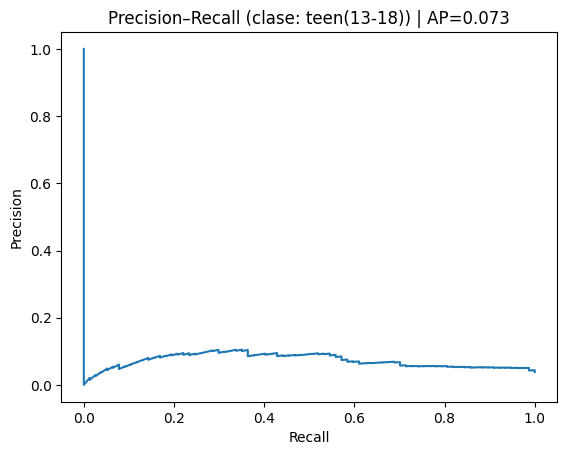

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

teen_index = 1
y_true_teen = (y_true_bucket == teen_index).astype(int)
y_score_teen = pred_bucket_prob[:, teen_index]

precision, recall, thresholds = precision_recall_curve(y_true_teen, y_score_teen)
ap = average_precision_score(y_true_teen, y_score_teen)

plt.figure()
plt.plot(recall, precision)
plt.title(f"Precision–Recall (clase: {CLASS_NAMES[teen_index]}) | AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

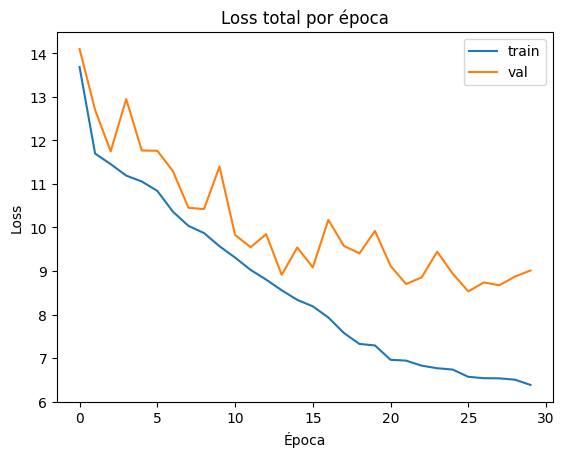

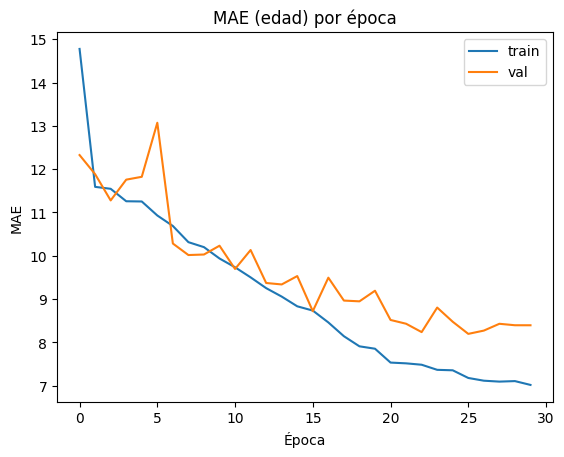

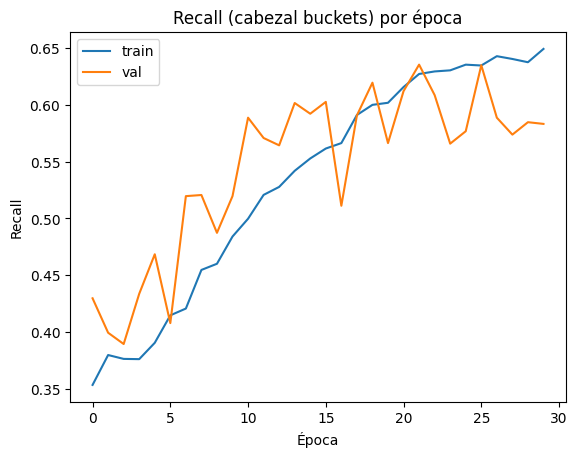

In [28]:
H = history.history  # dict

# Loss total
if "loss" in H and "val_loss" in H:
    plt.figure()
    plt.plot(H["loss"], label="train")
    plt.plot(H["val_loss"], label="val")
    plt.title("Loss total por época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MAE de edad (cabezal de regresión)
if "age_mae" in H and "val_age_mae" in H:
    plt.figure()
    plt.plot(H["age_mae"], label="train")
    plt.plot(H["val_age_mae"], label="val")
    plt.title("MAE (edad) por época")
    plt.xlabel("Época")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

# Recall de buckets (en especial adolescentes en validación)
# Nota: Keras registra 'bucket_recall' y 'val_bucket_recall' para la cabeza de clasificación
if "bucket_recall" in H and "val_bucket_recall" in H:
    plt.figure()
    plt.plot(H["bucket_recall"], label="train")
    plt.plot(H["val_bucket_recall"], label="val")
    plt.title("Recall (cabezal buckets) por época")
    plt.xlabel("Época")
    plt.ylabel("Recall")
    plt.legend()
    plt.show()

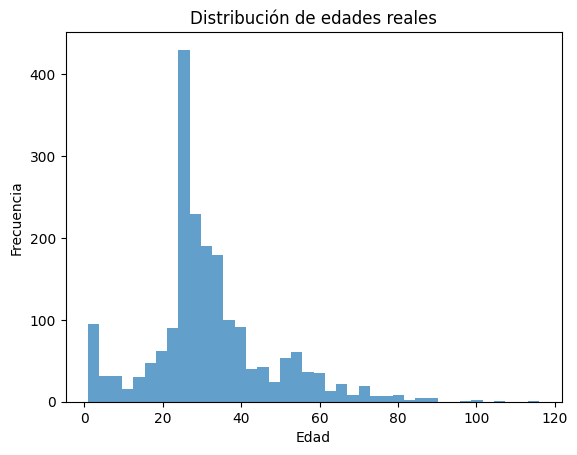

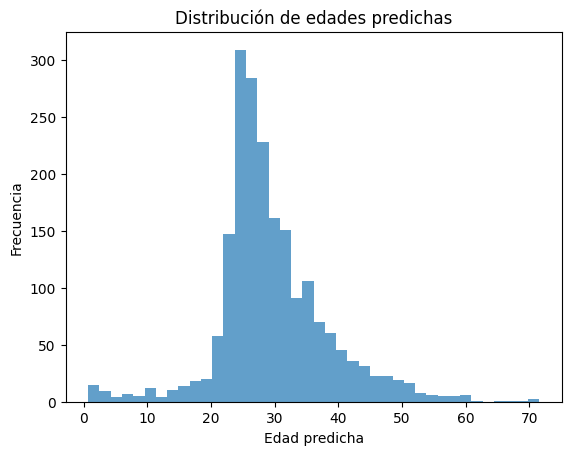

In [29]:
plt.figure()
plt.hist(y_true_age, bins=40, alpha=0.7)
plt.title("Distribución de edades reales")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

plt.figure()
plt.hist(pred_age, bins=40, alpha=0.7)
plt.title("Distribución de edades predichas")
plt.xlabel("Edad predicha")
plt.ylabel("Frecuencia")
plt.show()